# ML & AI CAPSTONE Project

In this notebook, we focus on enhancing the predictive performance of a ML Regression model used to predict the **Volumen** target variable based on several features.

Since Volumen can be influence by a lot of external variables, we will focus our approach in determining the importance, relevance and/or influence of features (in this case, automotive industry's incentives) in the outcome, **Volumen**. 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import shap

import warnings
warnings.filterwarnings('ignore')

In [23]:
df = pd.read_excel('../data/Reporte_de_Incentivos_GM_AI.xlsx', header=0)
df = df.fillna(0)

In [24]:
df.head()

,MODEL/SEGMENT,Date,UID,Make,Model,Version,Model year,Body Type,Transmission,Doors,...,Free Mantenaince,Valid Since,Valid Until,Volumen,Plan Cost,Monthly Payment,Commission Cost,Insurance Cost,Total Finance,GM Segment
0,CORVETTE,2023-07-01,8338421,Acura,Integra,1.5 A-SPEC CVT,2024,LB,Automático,5,...,0.0,2023-06-30,2023-07-31,1,9743.496252,22265.898498,19122.75,36216.52,28866.246252,Luxury Car-2
1,ENCLAVE/XT5/ACADIA,2023-07-01,8302827,Acura,RDX,2.0 ADVANCE AUTO AWD,2023,OD,Automático,5,...,0.0,2023-06-30,2023-07-31,26,79244.032125,29197.215315,21373.10,37949.31,79244.032125,Luxury SUV-3
2,ENCLAVE/XT5/ACADIA,2023-07-01,8019786,Acura,RDX,2.0 A-SPEC AUTO AWD,2023,OD,Automático,5,...,0.0,2023-06-30,2023-07-31,13,84175.210299,31014.092435,22703.10,39936.90,84175.210299,Luxury SUV-3
3,SEDAN,2023-07-01,8226879,Acura,TLX,2.0 ADVANCE AUTO,2023,SA,Automático,4,...,0.0,2023-06-30,2023-07-31,3,12609.567637,28815.462711,24747.75,38314.80,37357.317637,Luxury Car-3
4,SEDAN,2023-07-01,8306557,Acura,TLX,3.0 TYPE S AUTO AWD,2023,SA,Automático,4,...,0.0,2023-06-30,2023-07-31,1,15475.639022,35365.026924,30372.75,46007.44,45848.389022,Luxury Car-3


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16132 entries, 0 to 16131
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   MODEL/SEGMENT       16132 non-null  object        
 1   Date                16132 non-null  datetime64[ns]
 2   UID                 16132 non-null  int64         
 3   Make                16132 non-null  object        
 4   Model               16132 non-null  object        
 5   Version             16132 non-null  object        
 6   Model year          16132 non-null  int64         
 7   Body Type           16132 non-null  object        
 8   Transmission        16132 non-null  object        
 9   Doors               16132 non-null  int64         
 10  MSRP                16132 non-null  float64       
 11  Final Price         16132 non-null  int64         
 12  Down Payment        16132 non-null  float64       
 13  Term Since          16132 non-null  float64   

In [26]:
# Remove Non-needed or irrelevant Columns
columns_to_drop = ['Body Type','Transmission', 'Doors', 'Promotion 1','Promotion 2','Promotion 3','Name Plan']
df_dropped = df.drop(columns=columns_to_drop)

# Now I'll drop datetime cells for testing purposes:
datetime_cols = ['Valid Since', 'Valid Until', 'Date']
df_dropped = df_dropped.drop(columns=datetime_cols)

df_dropped = df_dropped[df_dropped['GM Segment'] != '0']

df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16132 entries, 0 to 16131
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MODEL/SEGMENT       16132 non-null  object 
 1   UID                 16132 non-null  int64  
 2   Make                16132 non-null  object 
 3   Model               16132 non-null  object 
 4   Version             16132 non-null  object 
 5   Model year          16132 non-null  int64  
 6   MSRP                16132 non-null  float64
 7   Final Price         16132 non-null  int64  
 8   Down Payment        16132 non-null  float64
 9   Term Since          16132 non-null  float64
 10  Term Until          16132 non-null  float64
 11  Rate                16132 non-null  float64
 12  Residual            16132 non-null  float64
 13  Opening Commission  16132 non-null  float64
 14  Subsidized Plan     16132 non-null  object 
 15  Plan Type           16132 non-null  object 
 16  Disc

In [27]:
# "Fix" the Boolean column Y/N to 1/0
df_dropped['Subsidized Plan'] = df_dropped['Subsidized Plan'].replace({'Y':1 , 'N':0})
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16132 entries, 0 to 16131
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MODEL/SEGMENT       16132 non-null  object 
 1   UID                 16132 non-null  int64  
 2   Make                16132 non-null  object 
 3   Model               16132 non-null  object 
 4   Version             16132 non-null  object 
 5   Model year          16132 non-null  int64  
 6   MSRP                16132 non-null  float64
 7   Final Price         16132 non-null  int64  
 8   Down Payment        16132 non-null  float64
 9   Term Since          16132 non-null  float64
 10  Term Until          16132 non-null  float64
 11  Rate                16132 non-null  float64
 12  Residual            16132 non-null  float64
 13  Opening Commission  16132 non-null  float64
 14  Subsidized Plan     16132 non-null  int64  
 15  Plan Type           16132 non-null  object 
 16  Disc

In [28]:
#Now filter our DF based on the Segment. This will allow us to get more accurate predictions, based on each segment.
segment_filter = df_dropped['GM Segment'] == 'Car-C'
df_segment = df_dropped[segment_filter]

In [29]:
# Separate features, which are only the incentives, and target variable which is volume
X = df_segment.loc[:, ['Insurance Cost', 'Commission Cost', 'Plan Cost', 'Free Mantenaince', 'Discount', 'Bonus' ]]
y = df_segment['Volumen']

In [30]:
X

,Insurance Cost,Commission Cost,Plan Cost,Free Mantenaince,Discount,Bonus
139,24806.43,15445.690,0.000000,0.0,0.0,18000.0
140,26349.41,16904.290,0.000000,0.0,0.0,18000.0
247,20658.94,13632.750,0.000000,0.0,0.0,0.0
248,21977.40,14735.250,0.000000,0.0,0.0,0.0
249,19044.50,12282.750,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...
16077,10440.59,9284.544,0.000000,0.0,0.0,0.0
16107,10528.04,9047.792,11507.222426,0.0,0.0,0.0
16108,13064.84,7903.792,10822.089607,0.0,0.0,0.0
16109,10434.79,8319.792,11391.688214,0.0,0.0,0.0


In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,Insurance Cost,Commission Cost,Plan Cost,Free Mantenaince,Discount,Bonus
7703,12158.930000,9160.200,0.000000,0.0,0.0,0.0
1283,30840.770000,9100.000,0.000000,0.0,0.0,0.0
14187,12869.780000,7694.400,0.000000,0.0,5000.0,0.0
2174,33865.120000,11024.750,11089.807495,0.0,0.0,0.0
11363,11037.430000,7396.200,1389.560679,0.0,0.0,0.0
...,...,...,...,...,...,...
14192,10362.490000,5166.400,0.000000,0.0,5000.0,0.0
14940,10861.740000,6550.200,3124.302890,0.0,0.0,0.0
15363,11180.830000,7399.800,0.000000,0.0,0.0,0.0
12085,20698.490000,11608.200,0.000000,0.0,0.0,0.0


In [32]:
#Let's try first with a Linear Regression model
lgr = LinearRegression().fit(X_train,y_train)
lgr.score(X_test,y_test)

0.06817087104797981

As you can see, it seems a Linear Regression model is not suitable for my model. 

Pretty poor score. I'll switch to **Essemble Models** instead:

In [33]:
# Create a Random Forest model
random_forest_model = RandomForestRegressor(random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Evaluate the model
random_forest_score = random_forest_model.score(X_test, y_test)
print("Random Forest Score:", random_forest_score)

Random Forest Score: 0.5255474735039196


#### How can we interpret this score?

The **R2 value**, or the coefficient of determination, is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by independent variables in a regression model. It provides a measure of how well the observed outcomes are replicated by the model based on the proportion of total variation of outcomes explained by the model.

- R2 =1: The model perfectly predicts the target variable without any error.

- R=0: The model is as good (or bad) as a model that simply predicts the mean of the target variable.

- R<0: The model is worse than a model that simply predicts the mean of the target variable.


In our case, Random Forest Score for **R2 = 0.5255**:

This means that approximately 52.55% of the variability in the dependent variable (y_test) can be explained by the features (independent variables) in your model. In other words, the model accounts for 52.55% of the variance in the target variable. While this is better than a model with an R2 of 0 (which would mean it's no better than just predicting the mean of the target variable for all observations), there's still significant room for improvement, as the model doesn't capture almost half of the variance.

**Hyperparameter Tunig:**

In [34]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400],
    'max_depth': [None, 5, 10, 20, 30, 40, 50, 60],
    'min_samples_leaf': [0.1, 0.5, 1, 2, 5, 10],
    'min_samples_split': [2, 5, 10, 15, 20, 25],
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.7]
}

In [35]:
# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, 
                           scoring='r2', cv=5, n_jobs=-1)

# Perform grid search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best R-squared Score:", best_score)

Best Parameters: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 250}
Best R-squared Score: 0.5038462893460982


In [36]:
# Create a Random Forest model with the best parameters
best_random_forest_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=10,
    max_features='auto',
    random_state=42
)

# Train the best model on the training data
best_random_forest_model.fit(X_train, y_train)

# Evaluate the best model on the test data
best_random_forest_score = best_random_forest_model.score(X_test, y_test)
print("Best Random Forest Score:", best_random_forest_score)

Best Random Forest Score: 0.5341157899228444


Let's try another approach on Hyperparameter Tuning:

**Expand Grid Search:**

- Wider Range: Let's the range of hyperparameters in your param_grid. Maybe there are better parameters outside the current range we've defined.
- Randomized Search: Instead of an exhaustive grid search, use RandomizedSearchCV. It samples a given number of candidates from a parameter space with a specified distribution. This often leads to discovering better hyperparameters faster.

In [37]:
# Expanded hyperparameter grid
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400],
    'max_depth': [None, 5, 10, 20, 30, 40, 50, 60],
    'min_samples_leaf': [0.1, 0.5, 1, 2, 5, 10],
    'min_samples_split': [2, 5, 10, 15, 20, 25],
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.7]
}

random_search = RandomizedSearchCV(
    estimator=random_forest_model, 
    param_distributions=param_dist,
    n_iter=100,  # number of iterations
    scoring='r2',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Get the best parameters and score
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print("Best Parameters from Randomized Search:", best_params_random)
print("Best R-squared Score from Randomized Search:", best_score_random)

Best Parameters from Randomized Search: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': None}
Best R-squared Score from Randomized Search: 0.5025800208181493


### Having a decent score, we can now start evaluating each of my features importance, which6 is the objective of my project:

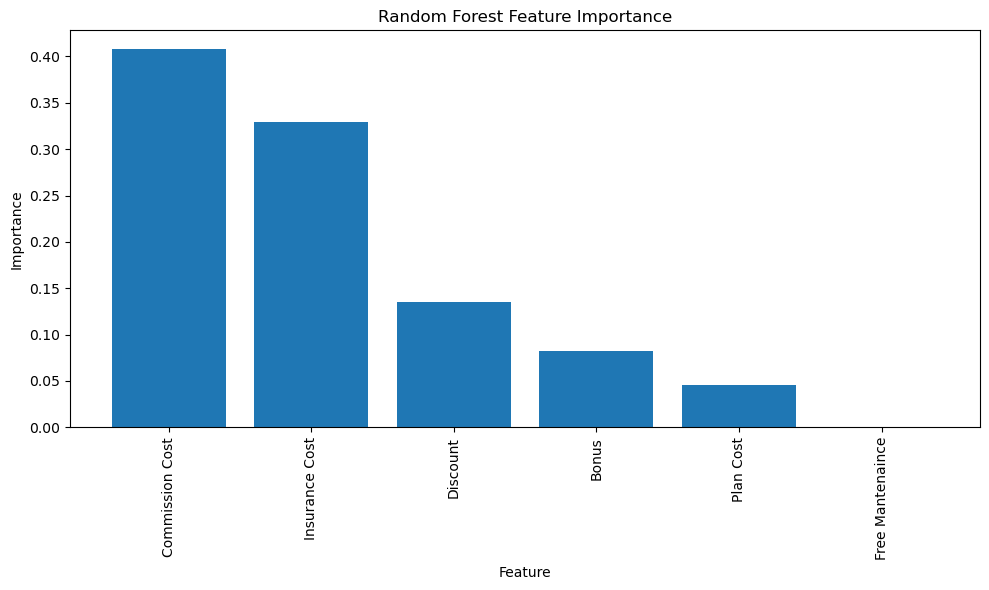

In [38]:
# Get feature importances from the trained Random Forest model
feature_importances = best_random_forest_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Sort the features based on importance
sorted_indices = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[sorted_indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

Having this, I 'll analyze each Segment and its feature importance:

In [39]:
# Get the list of unique segments
unique_segments = df_dropped['GM Segment'].unique()

# Create an empty dataframe to store feature importances for each segment
feature_importance_df = pd.DataFrame(columns=['Segment', 'Feature', 'Importance'])

# Loop through each segment and analyze feature importances
for segment in unique_segments:
    segment_filter = df_dropped['GM Segment'] == segment
    df_segment = df_dropped[segment_filter]
    
    # Separate features and target variable for the current segment
    X_segment = df_segment.loc[:, ['Insurance Cost', 'Commission Cost', 'Plan Cost', 'Free Mantenaince', 'Discount', 'Bonus']]
    y_segment = df_segment['Volumen']
    
    # Create a Random Forest model for the segment
    rf_model = RandomForestRegressor(
        n_estimators=150,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=10,
        max_features='auto',
        random_state=42
    )
    
    # Train the model on the segment data
    rf_model.fit(X_segment, y_segment)
    
    # Get feature importances
    feature_importances = rf_model.feature_importances_
    
    # Add feature importances to the dataframe
    for feature_idx, feature_name in enumerate(X_segment.columns):
        feature_importance_df = feature_importance_df.append({
            'Segment': segment,
            'Feature': feature_name,
            'Importance': feature_importances[feature_idx]
        }, ignore_index=True)

# Display the dataframe with feature importances for each segment
print(feature_importance_df)

# Optionally, save the dataframe to a CSV file
feature_importance_df.to_csv('../output_data/feature_importances_by_segment.csv', index=False)

          Segment           Feature  Importance
0    Luxury Car-2    Insurance Cost    0.296899
1    Luxury Car-2   Commission Cost    0.339947
2    Luxury Car-2         Plan Cost    0.118074
3    Luxury Car-2  Free Mantenaince    0.000000
4    Luxury Car-2          Discount    0.205215
..            ...               ...         ...
181       Truck-L   Commission Cost    0.445680
182       Truck-L         Plan Cost    0.044955
183       Truck-L  Free Mantenaince    0.000000
184       Truck-L          Discount    0.000704
185       Truck-L             Bonus    0.000000

[186 rows x 3 columns]


In [40]:
## Now including MSRP into the analysis:

# Get the list of unique segments
unique_segments = df_dropped['GM Segment'].unique()

# Create an empty dataframe to store feature importances for each segment
feature_importance_df = pd.DataFrame(columns=['Segment', 'Feature', 'Importance'])

# Loop through each segment and analyze feature importances
for segment in unique_segments:
    segment_filter = df_dropped['GM Segment'] == segment
    df_segment = df_dropped[segment_filter]
    
    # Separate features and target variable for the current segment
    X_segment = df_segment.loc[:, ['MSRP','Insurance Cost', 'Commission Cost', 'Plan Cost', 'Free Mantenaince', 'Discount', 'Bonus']]
    y_segment = df_segment['Volumen']
    
    # Create a Random Forest model for the segment
    rf_model = RandomForestRegressor(
        n_estimators=150,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=10,
        max_features='auto',
        random_state=42
    )
    
    # Train the model on the segment data
    rf_model.fit(X_segment, y_segment)
    
    # Get feature importances
    feature_importances = rf_model.feature_importances_
    
    # Add feature importances to the dataframe
    for feature_idx, feature_name in enumerate(X_segment.columns):
        feature_importance_df = feature_importance_df.append({
            'Segment': segment,
            'Feature': feature_name,
            'Importance': feature_importances[feature_idx]
        }, ignore_index=True)

# Display the dataframe with feature importances for each segment
print(feature_importance_df)

# Optionally, save the dataframe to a CSV file
feature_importance_df.to_csv('../output_data/feature_importances_by_segment_(wMSRP).csv', index=False)

          Segment           Feature  Importance
0    Luxury Car-2              MSRP    0.387529
1    Luxury Car-2    Insurance Cost    0.205267
2    Luxury Car-2   Commission Cost    0.139826
3    Luxury Car-2         Plan Cost    0.094728
4    Luxury Car-2  Free Mantenaince    0.000000
..            ...               ...         ...
212       Truck-L   Commission Cost    0.299498
213       Truck-L         Plan Cost    0.044342
214       Truck-L  Free Mantenaince    0.000000
215       Truck-L          Discount    0.001184
216       Truck-L             Bonus    0.000000

[217 rows x 3 columns]


## SHAP

I've done some research and SHAP (an acronym derived from SHapley Additive exPlanations) seems like an alternative to show features importance for my model.

SHAP values provide a powerful way to interpret machine learning models, especially tree-based models like Random Forest or Gradient Boosted Trees. The idea is based on game theory, where the contribution of each feature to a prediction is fairly allocated.

**Feature Importance:** The features are ordered by the sum of the SHAP value magnitudes over all samples. The most impactful feature is typically at the top, and the least impactful at the bottom. This provides a similar insight to feature importances in tree models, but with more nuance.

**Feature Impact Direction:** For a given feature, a point to the right of the "higher" mark means the feature is contributing positively to the model's prediction for that instance.
Conversely, a point to the left of the "lower" mark means it's contributing negatively.
Feature Value Color:

The color represents the value of the feature. For instance, if you have a binary feature, red might represent "True" and blue "False".
For continuous features, the color scale (usually blue to red) will show whether a feature's value is high or low. Blue might represent lower values and red higher values, or vice versa depending on the default setting.
Cluster of Points:

If you see a cluster of points on the high end for a feature and they’re all red, it suggests that whenever that feature has high values, it tends to increase the model's prediction.


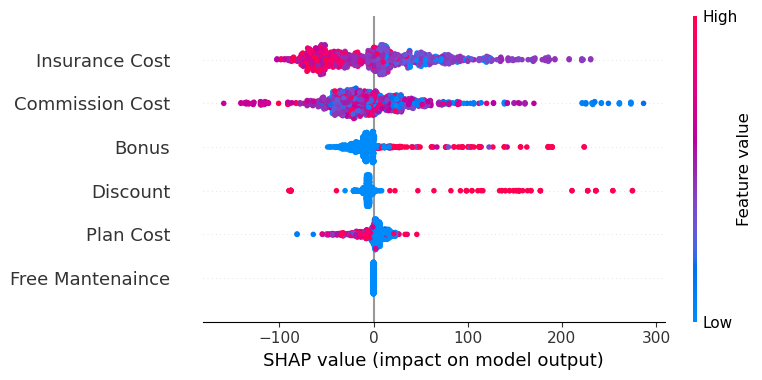

In [41]:
explainer = shap.TreeExplainer(best_random_forest_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

Now, let's have SHAP plots for every segment individually:

In [42]:
import os
import shap
import matplotlib.pyplot as plt

def sanitize_dir_name(name):
    str_name = str(name)  # Convert the input to a string
    return ''.join(e for e in str_name if e.isalnum())

# Ensure the main directory exists
main_dir = '../images/SHAP'
if not os.path.exists(main_dir):
    os.makedirs(main_dir)

# Get the list of unique segments
unique_segments = df_dropped['GM Segment'].unique()

# Loop through each segment and analyze using SHAP
for segment in unique_segments:
    print(f"Processing segment: {segment}")  # Debug print
    
    segment_filter = df_dropped['GM Segment'] == segment
    df_segment = df_dropped[segment_filter]
    
    # Separate features and target variable for the current segment
    X_segment = df_segment.loc[:, ['Insurance Cost', 'Commission Cost', 'Plan Cost', 'Free Mantenaince', 'Discount', 'Bonus']]
    y_segment = df_segment['Volumen']
    
    # Create and train a Random Forest model for the segment
    rf_model = RandomForestRegressor(
        n_estimators=150,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=10,
        max_features='auto',
        random_state=42
    )
    rf_model.fit(X_segment, y_segment)
    
    # Compute SHAP values
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_segment)
    
    # Ensure a directory for this segment exists
    sanitized_segment = sanitize_dir_name(segment)
    segment_dir = f'{main_dir}/{sanitized_segment}'
    if not os.path.exists(segment_dir):
        os.makedirs(segment_dir)
    else:
        print(f"Directory {segment_dir} already exists.")  # Debug print
    
    # Plot SHAP summary and save it as PNG
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_segment, show=False)
    plt.savefig(f'{segment_dir}/summary_plot.png', bbox_inches='tight')
    plt.close()
    #print(f"Saved SHAP plot for segment: {segment}")  # Debug print


Processing segment: Luxury Car-2
Directory ../images/SHAP/LuxuryCar2 already exists.
Processing segment: Luxury SUV-3
Directory ../images/SHAP/LuxurySUV3 already exists.
Processing segment: Luxury Car-3
Directory ../images/SHAP/LuxuryCar3 already exists.
Processing segment: Luxury Car-1
Directory ../images/SHAP/LuxuryCar1 already exists.
Processing segment: Luxury Car-4
Directory ../images/SHAP/LuxuryCar4 already exists.
Processing segment: Luxury Car-5
Directory ../images/SHAP/LuxuryCar5 already exists.
Processing segment: Luxury SUV-4
Directory ../images/SHAP/LuxurySUV4 already exists.
Processing segment: Luxury SUV-2
Directory ../images/SHAP/LuxurySUV2 already exists.
Processing segment: 0
Directory ../images/SHAP/0 already exists.
Processing segment: Luxury SUV-5
Directory ../images/SHAP/LuxurySUV5 already exists.
Processing segment: Van-B
Directory ../images/SHAP/VanB already exists.
Processing segment: SUV-C
Directory ../images/SHAP/SUVC already exists.
Processing segment: MPV-D


# Depth of Interpretation:

Now, we will proceed and provide SHAP Dependence and SHAP Force Plots
Let's break down the steps:

Dependence Plots will be plotted for each feature for each segment. This shows the effect of a single feature across the whole dataset.

Force Plots are typically for individual predictions. For this, I will demonstrate how to save a force plot for a single (e.g., the first) prediction in the dataset. Saving force plots for each instance in a segment could become excessive, depending on your dataset's size.


**Summary Plot:** This is an aggregate of all the SHAP values for all the samples. It gives a high-level overview of feature importance and the direction of the relationship (positive or negative).

**Dependence Plot:** You can also plot SHAP values of a single feature against the actual values of that feature. This helps in visualizing complex non-linear relationships which might not be immediately obvious.

**Force Plot:** This breaks down the prediction for a single observation, showing which features pushed the model's prediction up or down, and by how much.

In [43]:
# Function to sanitize directory name
def sanitize_dir_name(name):
    return ''.join(e for e in str(name) if e.isalnum())

# Directory for saving the SHAP plots
main_dir = "../images/SHAP"

# Get the list of unique segments (excluding '0')
unique_segments = [segment for segment in df_dropped['GM Segment'].unique() if segment != '0']

# Iterate over each segment
for segment in unique_segments:
    print(f"Processing segment: {segment}")
    
    # Filter the data for the current segment
    segment_filter = df_dropped['GM Segment'] == segment
    df_segment = df_dropped[segment_filter]
    
    # Check if columns exist and select only the available ones
    available_features = ['Insurance Cost', 'Commission Cost', 'Plan Cost', 'Free Maintenance', 'Discount', 'Bonus']
    selected_features = [feat for feat in available_features if feat in df_segment.columns]
    
    # Separate features and target variable
    X_segment = df_segment.loc[:, selected_features]
    y_segment = df_segment['Volumen']
    
    # Train the Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=150,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=10,
        max_features='auto',
        random_state=42
    )
    rf_model.fit(X_segment, y_segment)
    
    # Compute the SHAP values
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_segment)
    
    # Ensure a directory for this segment exists
    sanitized_segment = sanitize_dir_name(segment)
    segment_dir = f'{main_dir}/{sanitized_segment}'
    if not os.path.exists(segment_dir):
        os.makedirs(segment_dir)
    
    # Create a SHAP Dependence plot for each feature
    for feature in X_segment.columns:
        shap.dependence_plot(
            feature,
            shap_values,
            X_segment,
            show=False
        )
        plt.savefig(f"{segment_dir}/{feature}_dependence_plot.png")
        plt.close()
        
    print(f"Saved SHAP dependence plots for segment: {segment}")

Processing segment: Luxury Car-2
Saved SHAP dependence plots for segment: Luxury Car-2
Processing segment: Luxury SUV-3
Saved SHAP dependence plots for segment: Luxury SUV-3
Processing segment: Luxury Car-3
Saved SHAP dependence plots for segment: Luxury Car-3
Processing segment: Luxury Car-1
Saved SHAP dependence plots for segment: Luxury Car-1
Processing segment: Luxury Car-4
Saved SHAP dependence plots for segment: Luxury Car-4
Processing segment: Luxury Car-5
Saved SHAP dependence plots for segment: Luxury Car-5
Processing segment: Luxury SUV-4
Saved SHAP dependence plots for segment: Luxury SUV-4
Processing segment: Luxury SUV-2
Saved SHAP dependence plots for segment: Luxury SUV-2
Processing segment: 0
Saved SHAP dependence plots for segment: 0
Processing segment: Luxury SUV-5
Saved SHAP dependence plots for segment: Luxury SUV-5
Processing segment: Van-B
Saved SHAP dependence plots for segment: Van-B
Processing segment: SUV-C
Saved SHAP dependence plots for segment: SUV-C
Proces

##### Let's see a Dependance Plot for an specific segment and show how to interpret it:

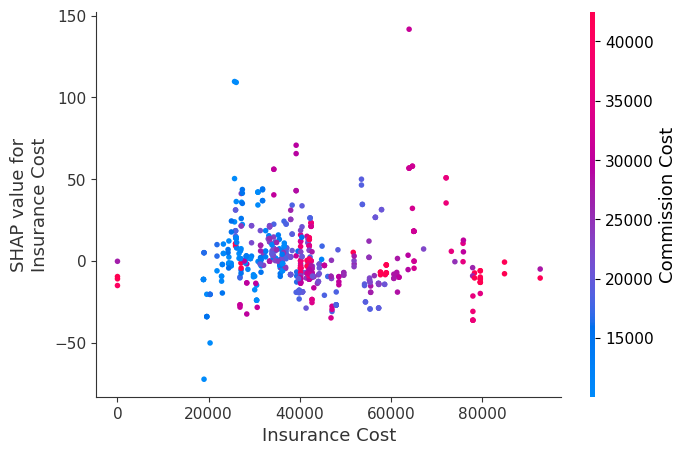

In [44]:
# Filtering the data for the segment "Luxury Car-2"
segment_filter = df_dropped['GM Segment'] == 'Pickup-E'
df_segment = df_dropped[segment_filter]

# Define the columns of interest
columns_of_interest = ['Insurance Cost', 'Commission Cost', 'Plan Cost', 'Discount', 'Bonus']

# Separate features and target variable
X_segment = df_segment.loc[:, columns_of_interest]
y_segment = df_segment['Volumen']

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=150, max_depth=None, min_samples_split=2, random_state=42)
rf_model.fit(X_segment, y_segment)

# Create SHAP values using the trained model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_segment)

# Plot the SHAP Dependence Plot for "Insurance Cost"
shap.dependence_plot("Insurance Cost", shap_values, X_segment, display_features=X_segment)

# Show the plot
plt.show()

#### SHAP Dependance Plot Explanation:

A SHAP Dependence Plot provides a visual understanding of the relationship between a single feature and the predicted outcome, while accounting for the effect of other features.

Here’s a step-by-step interpretation guide:

**1. Y-Axis (SHAP Value):**

The Y-axis represents the SHAP value for a feature. A positive SHAP value pushes the model's prediction higher (more positive), while a negative SHAP value pushes the prediction lower (more negative).
For a regression task, this means the model's output will increase or decrease. For a classification task, it means the probability of the positive class will increase or decrease.

**2. X-Axis (Feature Value):**

The X-axis displays the actual value of the feature for each instance in the dataset.

**3. Dot Position:**

Each dot represents an individual observation (row) in your dataset.
The horizontal position of the dot shows the actual value of the feature for that observation.
The vertical position indicates the SHAP value, showing how much that particular observation's feature value influenced the prediction.

**4. Dot Color:**

The color of the dots usually represents the value of another feature, providing a way to see interactions between the main feature and another feature. If a clear pattern emerges with the color of the dots, it suggests that the main feature's impact on the model's prediction changes depending on the value of another feature.

**5. Vertical Spread:**

If dots are scattered widely along the Y-axis for a specific value on the X-axis, it suggests high interaction effects between the selected feature and other features in the model.

**6. Trend Line:**

Some plots include a smoothed trend line. This line helps visualize the average effect of the feature value on the prediction.

#### How to Use the Plot:

- Feature Importance: Features with wider vertical spreads generally have a more significant impact on the model's prediction.

- Feature Interaction: If the color of the dots (representing another feature's value) shows a clear pattern or trend, it's an indication of interaction between the main feature and the feature represented by the color.

- Non-linearity: If the trend line isn't straight or has curves, it suggests that the model captures a non-linear relationship between the feature and the predicted outcome.

In [45]:
# Filtering the data for the segment "Luxury Car-2"
segment_filter = df_dropped['GM Segment'] == 'Pickup-E'
df_segment = df_dropped[segment_filter]

# Define the columns of interest
columns_of_interest = ['Insurance Cost', 'Commission Cost', 'Plan Cost', 'Discount', 'Bonus']

# Separate features and target variable
X_segment = df_segment.loc[:, columns_of_interest]
y_segment = df_segment['Volumen']

# Train the Random Forest model
rf_model = RandomForestRegressor(
        n_estimators=150,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=10,
        max_features='auto',
        random_state=42
)
    
rf_model.fit(X_segment, y_segment)



# Initialize the explainer
explainer = shap.TreeExplainer(rf_model)

base_value = explainer.expected_value

single_instance_shap_values = shap_values[0]


# Calculate SHAP values for the segment
shap_values = explainer.shap_values(X_segment)

shap.initjs()
shap.force_plot(base_value, single_instance_shap_values, X_segment.iloc[0])

#### SHAP Force Plot Explanation:

SHAP force plots provide an intuitive way to understand individual predictions by decomposing them into contributions from each feature. Let's break down how to interpret a force plot:

**1. Components of a Force Plot:**

- Base Value: This is the starting point of the prediction, which represents the average prediction for all instances in the training set.

- Output Value: This is the end value of the force plot, which is the actual prediction for the specific instance you're inspecting.

- Features: These are the individual factors pushing the prediction higher or lower compared to the base value. Each feature in the force plot has a weight (or force) associated with it, which is visually represented by the width of the arrow.

- Arrows (or Forces):

-  Red Arrows: These show the features that are pushing the prediction to increase from the base value. The wider the arrow, the larger the impact of that feature.
-  Blue Arrows: These represent features that push the prediction to decrease from the base value.

**2. Interpretation Steps:**

- Start with the Base Value: This is the model's prediction if it only considered the average of the dataset without any specific features of the instance in question. You can think of it as the "neutral" or "starting" prediction.

- Follow the Arrows: Look at the features and their corresponding arrows. They tell you which features had the most impact (positive or negative) on the prediction. The width of each arrow indicates the magnitude of the feature's impact.

- Compare Red vs. Blue: The balance of red (positive impact) and blue (negative impact) arrows will push the prediction from the base value towards the final output value.

- Final Output Value: At the end of all the arrows, you'll reach the model's actual prediction for that instance. It's the result of the base value plus all the positive and negative forces.

**3. Practical Insights:**

- Important Features: The most influential features for a given prediction are the ones with the widest arrows. By looking at these, you can quickly determine which factors most influenced a specific prediction.

- Unexpected Behaviors: If you're familiar with the domain, you can use the force plot to identify when the model is relying heavily on features that don't make intuitive sense. This can be an indicator of potential issues with the data or model.

- Contrastive Explanations: By comparing force plots of different instances, you can understand why the model predicted different values for them. It provides a contrastive explanation by highlighting which features differed most between instances.

**4. Limitations:**

- Overwhelming with Too Many Features: If the model has a large number of features, the force plot can become cluttered. It's often helpful to focus on the top N most influential features to make interpretation more manageable.


In summary, SHAP force plots are powerful tools for understanding the intricate details of individual predictions. They highlight the interplay of features in shaping the prediction, providing valuable insights for both experts and non-experts.